# Environment Configuration

Since I was using **Hortonworks Sandbox HDP 2.6.5** without any previous configuration, I will detail the proper steps to configure the system and the different programs in order to run the ETL process succesfully.

## Jupyter Notebook

To be able to run the `jupyter notebook` command, after Jupyter installation I needed to add its location to `~/.bashrc`:
  - `export PATH=$PATH:~/.local/bin`

## Python and PySpark

Since this sandbox has different versions of Spark (1.6.3 and 2.3.0) and Python (2.7.5 and 3.6.5), I had to define which one of them I wanted to use:
```
export SPARK_HOME=/usr/hdp/current/spark2-client
export PATH=$SPARK_HOME/bin:$PATH
export PYSPARK_PYTHON=python3.6
export PYSPARK_DRIVER_PYTHON=python3.6
```

### Required Python modules

I downloaded and installed **pip** module using Python 3 interpreter:
  1. `curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py`
  1. `python3.6 get-pip.py`

To later install **py4j** and **findspark** modules: 
  - `pip install py4j findspark`


### Findspark
Now we can use **findspark** (https://github.com/minrk/findspark) to be able to import **pyspark** module.<br>
Findspark sets some environment variables and adds dependencies to `sys.path`.

In [1]:
import findspark
findspark.init()

One final check before start the PySpark execution:

In [2]:
import os
print("PATH: %s\n" % os.environ['PATH'])
print("SPARK_HOME: %s" % os.environ['SPARK_HOME'])
print("PYSPARK_PYTHON: %s" % os.environ['PYSPARK_PYTHON'])
print("PYSPARK_DRIVER_PYTHON: %s" % os.environ['PYSPARK_DRIVER_PYTHON'])

PATH: /root/.local/bin:/usr/hdp/current/spark2-client/bin:/usr/lib64/qt-3.3/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/root/.local/bin:/root/bin

SPARK_HOME: /usr/hdp/current/spark2-client
PYSPARK_PYTHON: python3.6
PYSPARK_DRIVER_PYTHON: python3.6


## HDFS: Disabling secure mode

By default, HDFS comes with safe mode enabled, and this doesn't allow to create a **SparkSession**. <br> We can disable disable safe mode with the following command:

In [3]:
%%sh
sudo -u hdfs hdfs dfsadmin -safemode leave

Safe mode is OFF


# Datasets

I downloaded a total of 4 files from the following URL: 
https://www.kaggle.com/marcodena/mobile-phone-activity

**ISTAT_census_variables_2011.csv**<br>
STAT census 2011 variables, aggregated by Province (NUTS3)<br>
Original description: http://www.istat.it/it/archivio/104317

**Italian_provinces.geojson**<br>
Geojson file about the geography of Italian provinces.

**mi-to-provinces-2013-11-01.csv**<br>
Hourly phone calls, SMS and Internet interaction between single squares of the Milan Grid and the other Italian provinces. Date: 11-01-2013
  - **datetime**: Date in yyyy-mm-dd HH:ii format
  - **CellID**: identification string of a given square of Milan GRID
  - **provinceName**: the name of the Italian province
  - **cell2Province**: value representing the interaction between the Square id and the Province. It is proportional to the number of calls exchanged between callers, which are located in the Square id, and receivers located in the Province
  - **Province2cell**: Value representing the interaction between the Square id and the Province. It is proportional to the number of calls exchanged between callers, which are located in the Province, and receivers located in the Square id

**sms-call-internet-mi-2013-11-01.csv**<br>
Hourly phone calls, SMS and Internet communication of 11-01-2013
  - **datetime**: Date in yyyy-mm-dd HH:ii format
  - **CellID**: identification string of a given square of Milan GRID
  - **countrycode**: the phone country code of the nation
  - **smsin**: activity proportional to the amount of received SMSs inside a given Square id and during a given Time interval. The SMSs are sent from the nation identified by the Country code
  - **smsout**: activity proportional to the amount of sent SMSs inside a given Square id during a given Time interval. The SMSs are received in the nation identified by the Country code
  - **callin**: activity proportional to the amount of received calls inside the Square id during a given Time interval. The calls are issued from the nation identified by the Country code
  - **callout**: activity proportional to the amount of issued calls inside a given Square id during a given Time interval. The calls are received in the nation identified by the Country code
  - **internet**: number of CDRs generated inside a given Square id during a given Time interval. The Internet traffic is initiated from the nation identified by the Country code

Once I have downloaded all the dataset files to my host machine, the next steps were the following:

1. **Send the files to the VM** (Hortonworks Sandbox HDP 2.6.5): `scp -P 2222 file1 file2 root@sandbox.hdp.com:/tmp`
1. **Create the HDFS directory** path in which you are going to load the files: `hdfs dfs -mkdir -p /data/telecom`
1. **Copy the files to Hadoop filesystem** (previously, go to `/tmp` directory): `hdfs dfs -put file1 file2 /data/telecom`
1. **Check** that the files are properly loaded into Hadoop: `hdfs dfs -ls /data/telecom/file*`

**SSH trick**: To avoid typing the password every time you connect to the VM, the SSH must be configured between the host and VM.<br>
More info: https://www.ssh.com/ssh/keygen/

---

# PySpark ETL

## Create SparkSession

Starting from Spark 2.0, it is possible to create a **SparkSession**, which is essentially a combination of **SQLContext**, **HiveContext** and **StreamingContext**. 

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, initcap  # Some functions that later will be useful

spark = SparkSession \
        .builder \
        .appName("PySparkETLTelecom") \
        .getOrCreate()

## Loading the datasets

### ISTAT_census_variables_2011.csv

In [5]:
censusDF = spark.read.load("/data/telecom/ISTAT_census_variables_2011.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    inferSchema='true').cache()

A lot of the information in this dataset is related to population, but since we only need the province names, we can ignore the rest.<br>
Apart from this, we can also create a **view** so it can be used later in **SparkSQL**.

In [6]:
censusDF = censusDF.select("PROVINCIA")  # Overwrites DataFrame selecting only provinces field.
censusDF.createOrReplaceTempView("census")  # Creation of temporal view

`Describe` function can be useful to check quickly how many rows the DataFrame has, and some other properties more related to numbers than strings:

In [7]:
censusDF.describe().show()

+-------+---------+
|summary|PROVINCIA|
+-------+---------+
|  count|      110|
|   mean|     null|
| stddev|     null|
|    min|Agrigento|
|    max|  Viterbo|
+-------+---------+



And since we have now the view created, we can use **SparkSQL** to execute some query on it:

In [8]:
spark.sql("select * from census").show(5)

+-----------+
|  PROVINCIA|
+-----------+
|Alessandria|
|       Asti|
|     Biella|
|      Cuneo|
|     Novara|
+-----------+
only showing top 5 rows



### Italian_provinces.geojson

In [9]:
# Load Italian_provinces.geojson
provincesDF = spark.read.load("/data/telecom/Italian_provinces.geojson",
                    format='json',
                    multiline=True,
                    inferSchema='true').cache()

We didn't have information about this json file, but we can use the function `printSchema` to understand better how the data is structured in this field: 

In [10]:
provincesDF.printSchema()

root
 |-- crs: struct (nullable = true)
 |    |-- properties: struct (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- geometry: struct (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |-- properties: struct (nullable = true)
 |    |    |    |-- PROVINCIA: string (nullable = true)
 |    |    |    |-- SHAPE_AREA: double (nullable = true)
 |    |    |    |-- SIGLA: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- type: string (nullable = true)



The structure is quite complex, and we can easily see that the root level won't be very useful:

In [11]:
provincesDF.show()

+--------------------+--------------------+-----------------+
|                 crs|            features|             type|
+--------------------+--------------------+-----------------+
|[[urn:ogc:def:crs...|[[[[[[[460929.540...|FeatureCollection|
+--------------------+--------------------+-----------------+



Again, here we are interested in provinces, so we have to get into that nested value by writing the following:

In [12]:
provincesDF = provincesDF.select("features.properties.PROVINCIA")

In [13]:
provincesDF.show()  # All the provinces in a single line

+--------------------+
|           PROVINCIA|
+--------------------+
|[Novara, Torino, ...|
+--------------------+



But this is not exactly what we want. We are going to put each province in a single row, by using `explode` function:

In [14]:
provincesDF = provincesDF.select(explode("PROVINCIA")).withColumnRenamed("col", "PROVINCIA")

In [15]:
provincesDF.show(5)

+-----------+
|  PROVINCIA|
+-----------+
|     Novara|
|     Torino|
|   Vercelli|
|      Aosta|
|Alessandria|
+-----------+
only showing top 5 rows



Since this is what we want, we can now create the view:

In [16]:
provincesDF.createOrReplaceTempView("provinces")

### Decide which file use for provinces

**ISTAT_census_variables_2011.csv** VS **Italian_provinces.geojson**

Now we have loaded 2 files that look very similar once we focus only in the province field.

In [17]:
censusDF.describe().show()
provincesDF.describe().show()

+-------+---------+
|summary|PROVINCIA|
+-------+---------+
|  count|      110|
|   mean|     null|
| stddev|     null|
|    min|Agrigento|
|    max|  Viterbo|
+-------+---------+

+-------+---------+
|summary|PROVINCIA|
+-------+---------+
|  count|      110|
|   mean|     null|
| stddev|     null|
|    min|Agrigento|
|    max|  Viterbo|
+-------+---------+



But if we dig into their data trying to find the non-matching rows (using a **FULL OUTER JOIN**), we can see the differences:

In [18]:
spark.sql("""select c.PROVINCIA as census, p.PROVINCIA as provinces from
                (select distinct PROVINCIA from census) c 
                    full outer join 
                (select distinct PROVINCIA from provinces) p
                    on c.PROVINCIA = p.PROVINCIA
                where c.PROVINCIA is null or p.PROVINCIA is null
            """).show(truncate=False)

+----------------------------+-------------+
|census                      |provinces    |
+----------------------------+-------------+
|Bolzano/Bozen               |null         |
|null                        |Forli'-Cesena|
|Massa-Carrara               |null         |
|Forlì-Cesena                |null         |
|Valle d'Aosta/Vallée d'Aoste|null         |
|null                        |Bolzano      |
|null                        |Aosta        |
|null                        |Massa Carrara|
+----------------------------+-------------+



By instance:
 - **Forli'-Cesena** and **Forlì-Cesena**: Business user may decide to remove all or some of the punctuation and accents, so in this case both will be equal.
 -  **Bolzano/Bozen** and **Bolzano**: This could be another false positive, that can be solved by removing everything after `/` character.

Looking at these results, we decide to keep on with **provincesDF** DataFrame, so we remove **censusDF** from cache and view tables:

In [19]:
# DataFrame
censusDF.unpersist()
print(censusDF.is_cached)

# Temporal view
spark.catalog.dropTempView("census")
spark.sql("show tables").show()

False
+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |provinces|       true|
+--------+---------+-----------+



### mi-to-provinces-2013-11-01.csv

In [20]:
mitoprovincesDF = spark.read.load("/data/telecom/mi-to-provinces-2013-11-01.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    inferSchema='true').cache()

In [21]:
mitoprovincesDF.show(3)

+-------------------+------+------------+-------------+-------------+
|           datetime|CellID|provinceName|cell2Province|Province2cell|
+-------------------+------+------------+-------------+-------------+
|2013-11-01 00:00:00|     1|      MILANO|       0.1894|       0.0541|
|2013-11-01 00:00:00|     1|       PAVIA|       0.0273|         null|
|2013-11-01 00:00:00|     1|      TRENTO|       0.0261|         null|
+-------------------+------+------------+-------------+-------------+
only showing top 3 rows



This dataset has the province names in capital letters, so we are going to update the DataFrame capitalizing the name of the province:

In [22]:
mitoprovincesDF = mitoprovincesDF.withColumn("provinceName", initcap(mitoprovincesDF.provinceName))
mitoprovincesDF.show(3)

+-------------------+------+------------+-------------+-------------+
|           datetime|CellID|provinceName|cell2Province|Province2cell|
+-------------------+------+------------+-------------+-------------+
|2013-11-01 00:00:00|     1|      Milano|       0.1894|       0.0541|
|2013-11-01 00:00:00|     1|       Pavia|       0.0273|         null|
|2013-11-01 00:00:00|     1|      Trento|       0.0261|         null|
+-------------------+------+------------+-------------+-------------+
only showing top 3 rows



In [23]:
mitoprovincesDF.createOrReplaceTempView("mitoprovinces")

### sms-call-internet-mi-2013-11-01.csv

In [24]:
cdrDF = spark.read.load("/data/telecom/sms-call-internet-mi-2013-11-01.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    inferSchema='true').cache()

In [25]:
cdrDF.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     1|         33|  null|  null|  null|   null|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     2|         33|  null|  null|  null|   null|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



We can see that the dataset has a lot of **null** values, so we are going to replace them with some other value we define. 

In [26]:
cdrDF = cdrDF.na.fill(0)
cdrDF.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|   0.0|   0.0| 0.0273|     0.0|
|2013-11-01 00:00:00|     1|         33|   0.0|   0.0|   0.0|    0.0|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|   0.0|   0.0| 0.0273|     0.0|
|2013-11-01 00:00:00|     2|         33|   0.0|   0.0|   0.0|    0.0|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



In [27]:
cdrDF.createOrReplaceTempView("cdr")

## Business use case

At this point we have all the datasets loaded and cleaned, and all their temporal tables have been created.<br>
We can check the creation of these tables by executing the following:

In [28]:
spark.sql("show tables").show()

+--------+-------------+-----------+
|database|    tableName|isTemporary|
+--------+-------------+-----------+
|        |          cdr|       true|
|        |mitoprovinces|       true|
|        |    provinces|       true|
+--------+-------------+-----------+



**Note**<br>
The focus on the notebook was the engineering part: Show how to load different file formats into Spark DataFrames, do some data wrangling on them, analyse the data and check difference between similar files, etc.<br>
That's why the business use case is not going to be complex and only use one from the 4 original files (1 discarded after the comparison).

### Spark SQL

The idea is to create one final DataFrame that calculates the sum of activity of the different uses (GSM, SMS, Internet) for a group of countries.

In [29]:
aggcountryDF = spark.sql("""select 
                                CASE countrycode
                                    WHEN 7 THEN "Russia"
                                    WHEN 33 THEN "France"
                                    WHEN 34 THEN "Spain"
                                    WHEN 39 THEN "Italy"
                                    WHEN 44 THEN "United Kingdom"
                                    WHEN 47 THEN "Norway"
                                    WHEN 48 THEN "Poland"
                                    WHEN 49 THEN "Germany"
                                    WHEN 351 THEN "Portugal"
                                    WHEN 420 THEN "Czech Republic"
                                    ELSE "_Others_"
                                END as country,
                                round(sum(smsin),6) smsin, 
                                round(sum(smsout),6) smsout, 
                                round(sum(callin),6) callin, 
                                round(sum(callout),6) callout, 
                                round(sum(internet),6) internet
                            from cdr
                            where countrycode != 0
                            group by country
                            order by 1
                            """)

We can see here that Italy has most of the activity, and it makes sense since the data was gathered from that country:

In [30]:
aggcountryDF.show()

+--------------+------------+------------+------------+------------+---------------+
|       country|       smsin|      smsout|      callin|     callout|       internet|
+--------------+------------+------------+------------+------------+---------------+
|Czech Republic|   2608.1169|   1437.8024|    733.0263|    544.2075|      5488.8842|
|        France|  20495.0177|  13158.3234|    4527.906|   2984.4441|     36769.9342|
|       Germany|   9549.2932|   2747.5518|   1960.2404|   1396.1923|     23737.9411|
|         Italy|2889250.3153|2688729.4971|2560497.8263|2962224.2957|8.22452086458E7|
|        Norway|    745.8405|    535.5974|    190.2444|    149.5543|       1913.018|
|        Poland|   3821.9876|   1852.1156|   1176.1172|    861.9467|      3879.9327|
|      Portugal|    616.0036|    358.1073|    288.9737|    128.8219|       459.4812|
|        Russia|   8983.6104|   6108.6568|   4682.9862|    1710.748|      5509.7652|
|         Spain|   2301.3214|   1428.7563|   2178.4545|   1665.46

We can now save the previous DataFrame to a file (using **Parquet** format) in the disk so we don't have to recalculate every time all the steps:

In [31]:
aggcountryDF.write.mode("overwrite") \
            .format('parquet') \
            .save('/data/telecom/AggregatedCountries.parquet')

Now with the file created, we can ask for its data using either the load function or SQL directly to it:

In [32]:
spark.sql("SELECT upper(PROVINCIA) as Province FROM parquet.`/data/telecom/provinces.parquet`").show(3)
spark.read.load("/data/telecom/provinces.parquet", format='parquet').show(3)

+--------+
|Province|
+--------+
|  NOVARA|
|  TORINO|
|VERCELLI|
+--------+
only showing top 3 rows

+---------+
|PROVINCIA|
+---------+
|   Novara|
|   Torino|
| Vercelli|
+---------+
only showing top 3 rows



### Visualization

In [33]:
import matplotlib.pyplot as plt
import numpy as np

To be able to represent the data using the Matplotlib library, we first need to convert the **Spark** Dataframe to a **Pandas** DataFrame.<br>
The representation of this new DataFrame type is similar to the previously seen:

In [34]:
plotdf = aggcountryDF.where("country not in ('Italy','_Others_')").toPandas()
print(plotdf)

          country       smsin      smsout     callin    callout    internet
0  Czech Republic   2608.1169   1437.8024   733.0263   544.2075   5488.8842
1          France  20495.0177  13158.3234  4527.9060  2984.4441  36769.9342
2         Germany   9549.2932   2747.5518  1960.2404  1396.1923  23737.9411
3          Norway    745.8405    535.5974   190.2444   149.5543   1913.0180
4          Poland   3821.9876   1852.1156  1176.1172   861.9467   3879.9327
5        Portugal    616.0036    358.1073   288.9737   128.8219    459.4812
6          Russia   8983.6104   6108.6568  4682.9862  1710.7480   5509.7652
7           Spain   2301.3214   1428.7563  2178.4545  1665.4606  11389.0908
8  United Kingdom  11509.6936  11603.9780  3756.9092  2954.2486  23588.0875


Now we are going to generate 3 different plots, using the horizontal bar type:
- **SMS in and out**: `Country` for X axis; fields `smsin` and `smsout` for the Y axis.
- **Calls in and out**: `Country` for X axis; fields `callin` and `callout` for the Y axis.
- **Internet access**: `Country` for X axis; field `internet` for the Y axis.

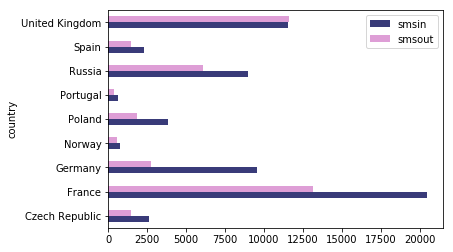

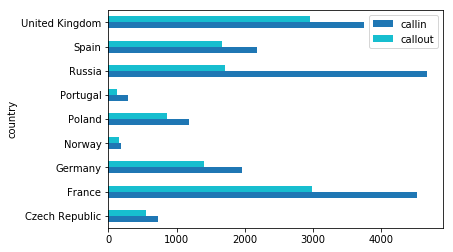

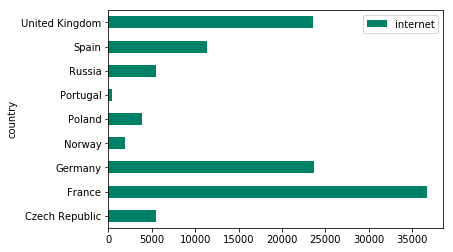

In [35]:
plotdf.plot(kind='barh', x='country', y=['smsin', 'smsout'], colormap='tab20b')
plotdf.plot(kind='barh', x='country', y=['callin', 'callout'], colormap='tab10')
plotdf.plot(kind='barh', x='country', y=['internet'], colormap='summer')

## End Spark session

Once we are done with the process, we can shutdown the Spark Session to let Spark master know that the application is finished consuming resources. 

In [36]:
spark.stop()